In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys, json, math, random
import numpy as np

PROJECT_ROOT = "/content/drive/MyDrive/AI_RL_Task_Scheduling"
DATA_DIR = f"{PROJECT_ROOT}/data"
SRC_DIR = f"{PROJECT_ROOT}/src"
MODELS_DIR = f"{PROJECT_ROOT}/models"
OUTPUTS_DIR = f"{PROJECT_ROOT}/outputs"

sys.path.append(SRC_DIR)


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

from sim_env import Task, Scheduler, SchedulerEnv, compute_metrics
from config import (
    N_TRAIN_TASKS, SEEDS, TOP_K,
    REWARD_COMPLETE, REWARD_WAITING_PENALTY, REWARD_DEADLINE_MISS,
    GAMMA, LEARNING_RATE, BATCH_SIZE, REPLAY_BUFFER_SIZE,
    EPS_START, EPS_END, TARGET_UPDATE_STEPS
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
def load_tasks_jsonl(path):
    tasks = []
    with open(path, "r") as f:
        for line in f:
            d = json.loads(line)
            ptime = int(d["processing_time"])
            tasks.append(Task(
                task_id=int(d["task_id"]),
                arrival_time=int(d["arrival_time"]),
                processing_time=ptime,
                deadline=int(d["deadline"]),
                remaining_time=ptime
            ))
    return tasks

TRAIN_WORKLOADS = ["uniform", "bursty", "heavy_tailed", "deadline_constrained"]

def get_train_paths():
    paths = []
    for w in TRAIN_WORKLOADS:
        for seed in SEEDS:
            paths.append(f"{DATA_DIR}/{w}_train_seed{seed}.jsonl")
    return paths

train_paths = get_train_paths()
train_paths[:3], len(train_paths)


(['/content/drive/MyDrive/AI_RL_Task_Scheduling/data/uniform_train_seed0.jsonl',
  '/content/drive/MyDrive/AI_RL_Task_Scheduling/data/uniform_train_seed1.jsonl',
  '/content/drive/MyDrive/AI_RL_Task_Scheduling/data/uniform_train_seed2.jsonl'],
 12)

In [4]:
class RLSimRunner:
    """
    Wraps SchedulerEnv to compute RL reward at each step.
    """
    def __init__(self, tasks, scheduler, max_time=200000):
        self.env = SchedulerEnv(tasks, scheduler, max_time=max_time)
        self.t = 0

    def is_done(self):
        return not (self.env.task_ptr < len(self.env.tasks) or len(self.env.ready_queue) > 0)

    def step_with_choice(self, chosen_idx: int):
        """
        Executes one time step, forcing selection = chosen_idx in ready_queue.
        Returns reward, done, optional info.
        """
        # --- replicate env.step() but with forced action ---
        # 1) arrivals
        while self.env.task_ptr < len(self.env.tasks) and self.env.tasks[self.env.task_ptr].arrival_time <= self.env.time:
            self.env.ready_queue.append(self.env.tasks[self.env.task_ptr])
            self.env.task_ptr += 1

        reward = 0.0
        info = {}

        if self.env.ready_queue:
            idx = chosen_idx
            task = self.env.ready_queue[idx]

            if task.start_time is None:
                task.start_time = self.env.time

            task.remaining_time -= 1

            # waiting penalty (penalize number of waiting tasks)
            waiting_count = len(self.env.ready_queue) - 1
            reward -= REWARD_WAITING_PENALTY * waiting_count

            # others waiting_time++
            for i, other in enumerate(self.env.ready_queue):
                if i != idx:
                    other.waiting_time += 1

            # completion
            if task.is_complete():
                task.completion_time = self.env.time + 1
                self.env.completed_tasks.append(task)
                self.env.ready_queue.pop(idx)
                reward += REWARD_COMPLETE

                # deadline miss penalty ONLY if this completed task is late
                if task.completion_time > task.deadline:
                    reward -= REWARD_DEADLINE_MISS

        self.env.time += 1
        done = self.is_done()
        return reward, done, info


In [5]:
def encode_state(ready_queue, t, max_deadline_horizon=200.0, max_wait=200.0, max_rem=50.0):
    """
    State = [K tasks * (rem_norm, ttd_norm, wait_norm)] + [queue_len_norm, avg_wait_norm]
    Tasks ordered by (deadline, remaining_time, task_id) for stability.
    """
    # sort for state view (does NOT force policy)
    rq = sorted(ready_queue, key=lambda x: (x.deadline, x.remaining_time, x.task_id))

    feats = []
    # per-task features
    for i in range(TOP_K):
        if i < len(rq):
            rem = rq[i].remaining_time / max_rem
            ttd = (rq[i].deadline - t) / max_deadline_horizon
            wait = rq[i].waiting_time / max_wait
            feats.extend([rem, ttd, wait])
        else:
            feats.extend([0.0, 0.0, 0.0])

    # global features
    qlen = len(ready_queue) / 50.0
    avg_wait = (np.mean([x.waiting_time for x in ready_queue]) if ready_queue else 0.0) / max_wait
    feats.extend([qlen, avg_wait])

    return np.array(feats, dtype=np.float32)

def valid_action_mask(ready_queue):
    """
    Returns mask of length TOP_K: True if action valid else False.
    Valid actions correspond to indices within the *state ordering*.
    We'll map action->task via the same sorted view.
    """
    m = np.zeros(TOP_K, dtype=np.bool_)
    m[:min(len(ready_queue), TOP_K)] = True
    return m

def get_sorted_view(ready_queue):
    return sorted(ready_queue, key=lambda x: (x.deadline, x.remaining_time, x.task_id))


In [6]:
STATE_DIM = TOP_K * 3 + 2
ACTION_DIM = TOP_K

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)

    def push(self, s, a, r, s2, done, mask2):
        self.buf.append((s, a, r, s2, done, mask2))

    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s, a, r, s2, done, mask2 = map(np.array, zip(*batch))
        return s, a, r, s2, done, mask2

    def __len__(self):
        return len(self.buf)

policy_net = DQN(STATE_DIM, ACTION_DIM).to(device)
target_net = DQN(STATE_DIM, ACTION_DIM).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)


In [7]:
def epsilon_by_step(step, total_decay_steps=50_000):
    # linear decay
    frac = min(step / total_decay_steps, 1.0)
    return EPS_START + frac * (EPS_END - EPS_START)

@torch.no_grad()
def select_action(state_np, mask_np, step):
    eps = epsilon_by_step(step)
    if random.random() < eps:
        valid_idxs = np.where(mask_np)[0]
        return int(np.random.choice(valid_idxs))
    else:
        s = torch.tensor(state_np, device=device).unsqueeze(0)
        q = policy_net(s).squeeze(0).detach().cpu().numpy()
        q[~mask_np] = -1e9
        return int(np.argmax(q))


In [8]:
def train_step():
    if len(buffer) < BATCH_SIZE:
        return None

    s, a, r, s2, done, mask2 = buffer.sample(BATCH_SIZE)

    s_t = torch.tensor(s, device=device)
    a_t = torch.tensor(a, device=device, dtype=torch.int64).unsqueeze(1)
    r_t = torch.tensor(r, device=device, dtype=torch.float32).unsqueeze(1)
    s2_t = torch.tensor(s2, device=device)
    done_t = torch.tensor(done, device=device, dtype=torch.float32).unsqueeze(1)
    mask2_t = torch.tensor(mask2, device=device, dtype=torch.bool)

    q_sa = policy_net(s_t).gather(1, a_t)

    with torch.no_grad():
        q2 = target_net(s2_t)
        # mask invalid next actions
        q2[~mask2_t] = -1e9
        max_q2 = q2.max(dim=1, keepdim=True).values
        target = r_t + GAMMA * (1.0 - done_t) * max_q2

    loss = nn.MSELoss()(q_sa, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return float(loss.item())


In [9]:
def train_dqn(num_episodes=250):
    global_step = 0
    losses = []
    ep_returns = []

    for ep in range(num_episodes):
        # pick a random training workload file each episode
        path = random.choice(train_paths)
        tasks = load_tasks_jsonl(path)

        # We need a scheduler object, but RL chooses actions; we use a dummy
        class Dummy(Scheduler):
            def select_task(self, ready_queue, t):  # not used
                return 0

        runner = RLSimRunner(tasks, Dummy(), max_time=300000)

        total_reward = 0.0
        last_loss = None

        while not runner.is_done():
            rq = runner.env.ready_queue
            t = runner.env.time

            # encode state + mask based on current ready_queue
            state = encode_state(rq, t)
            mask = valid_action_mask(get_sorted_view(rq))  # mask in sorted view space

            # if queue empty, just advance (no choice)
            if not rq:
                reward, done, _ = runner.step_with_choice(0)
                total_reward += reward
                continue

            # choose action in sorted-view space
            action = select_action(state, mask, global_step)

            # map action to actual index in env.ready_queue:
            # we select from sorted view, then find its index in actual ready_queue
            sorted_rq = get_sorted_view(rq)
            chosen_task = sorted_rq[action]
            actual_idx = runner.env.ready_queue.index(chosen_task)

            reward, done, _ = runner.step_with_choice(actual_idx)
            total_reward += reward

            # next state
            rq2 = runner.env.ready_queue
            t2 = runner.env.time
            state2 = encode_state(rq2, t2)
            mask2 = valid_action_mask(get_sorted_view(rq2))

            buffer.push(state, action, reward, state2, done, mask2)

            # optimize
            loss = train_step()
            if loss is not None:
                last_loss = loss
                losses.append(loss)

            # target update
            if global_step % TARGET_UPDATE_STEPS == 0 and global_step > 0:
                target_net.load_state_dict(policy_net.state_dict())

            global_step += 1

        ep_returns.append(total_reward)

        if (ep + 1) % 10 == 0:
            print(f"Episode {ep+1}/{num_episodes} | return={total_reward:.2f} | last_loss={last_loss}")

    return ep_returns, losses

ep_returns, losses = train_dqn(num_episodes=250)


Episode 10/250 | return=-27324.40 | last_loss=0.2752285301685333
Episode 20/250 | return=-9571.95 | last_loss=0.4340173304080963
Episode 30/250 | return=-27050.73 | last_loss=0.7396746873855591
Episode 40/250 | return=-8079.24 | last_loss=0.5795052647590637
Episode 50/250 | return=-8083.07 | last_loss=0.2860144376754761
Episode 60/250 | return=-26774.51 | last_loss=0.42680948972702026
Episode 70/250 | return=-9562.39 | last_loss=1.3440496921539307
Episode 80/250 | return=-9570.15 | last_loss=0.9218230843544006
Episode 90/250 | return=-19830.08 | last_loss=0.8533507585525513
Episode 100/250 | return=-27051.51 | last_loss=0.6491599082946777
Episode 110/250 | return=-15024.74 | last_loss=1.6615983247756958
Episode 120/250 | return=-27334.99 | last_loss=0.9819611310958862
Episode 130/250 | return=-8106.94 | last_loss=1.272049903869629
Episode 140/250 | return=-19828.99 | last_loss=0.653038501739502
Episode 150/250 | return=-9577.47 | last_loss=0.5891114473342896
Episode 160/250 | return=-9

Saved model: /content/drive/MyDrive/AI_RL_Task_Scheduling/models/dqn.pt


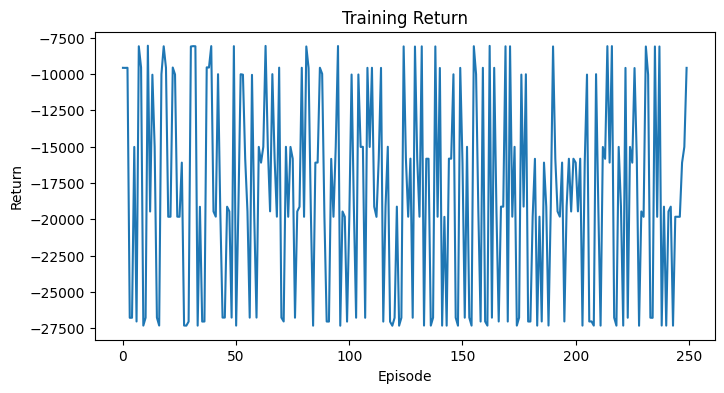

Saved: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/training_return.png


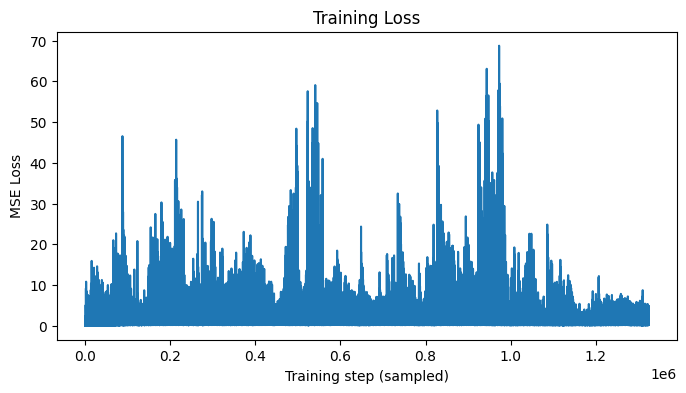

Saved: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/training_loss.png
Saved: /content/drive/MyDrive/AI_RL_Task_Scheduling/outputs/training_config.json


In [10]:
import json
from datetime import datetime

# Save model
model_path = f"{MODELS_DIR}/dqn.pt"
torch.save(policy_net.state_dict(), model_path)
print("Saved model:", model_path)

# Curves
plt.figure(figsize=(8,4))
plt.plot(ep_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Training Return")
ret_fig = f"{OUTPUTS_DIR}/training_return.png"
plt.savefig(ret_fig, dpi=200)
plt.show()
print("Saved:", ret_fig)

plt.figure(figsize=(8,4))
plt.plot(losses)
plt.xlabel("Training step (sampled)")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
loss_fig = f"{OUTPUTS_DIR}/training_loss.png"
plt.savefig(loss_fig, dpi=200)
plt.show()
print("Saved:", loss_fig)

# Save training config snapshot
train_cfg = {
    "timestamp": datetime.now().isoformat(),
    "device": str(device),
    "STATE_DIM": STATE_DIM,
    "ACTION_DIM": ACTION_DIM,
    "TOP_K": TOP_K,
    "train_workloads": TRAIN_WORKLOADS,
    "train_paths_count": len(train_paths),
    "num_episodes": len(ep_returns),
    "gamma": GAMMA,
    "lr": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "replay_buffer": REPLAY_BUFFER_SIZE,
    "eps_start": EPS_START,
    "eps_end": EPS_END,
    "target_update_steps": TARGET_UPDATE_STEPS,
    "reward_complete": REWARD_COMPLETE,
    "reward_waiting_penalty": REWARD_WAITING_PENALTY,
    "reward_deadline_miss": REWARD_DEADLINE_MISS,
}
cfg_path = f"{OUTPUTS_DIR}/training_config.json"
with open(cfg_path, "w") as f:
    json.dump(train_cfg, f, indent=2)
print("Saved:", cfg_path)


In [11]:
@torch.no_grad()
def run_greedy_policy(tasks):
    class Dummy(Scheduler):
        def select_task(self, ready_queue, t): return 0

    runner = RLSimRunner(tasks, Dummy(), max_time=300000)

    while not runner.is_done():
        rq = runner.env.ready_queue
        t = runner.env.time

        # arrivals happen inside step_with_choice, so if queue empty, just step
        if not rq:
            runner.step_with_choice(0)
            continue

        state = encode_state(rq, t)
        sorted_rq = get_sorted_view(rq)
        mask = valid_action_mask(sorted_rq)

        s = torch.tensor(state, device=device).unsqueeze(0)
        q = policy_net(s).squeeze(0).detach().cpu().numpy()
        q[~mask] = -1e9
        a = int(np.argmax(q))

        chosen_task = sorted_rq[a]
        actual_idx = runner.env.ready_queue.index(chosen_task)
        runner.step_with_choice(actual_idx)

    return runner.env.completed_tasks

# load one dataset and test
test_tasks = load_tasks_jsonl(train_paths[0])
completed = run_greedy_policy(test_tasks)
compute_metrics(completed)


{'avg_waiting_time': np.float64(1498.638),
 'deadline_miss_rate': 0.982,
 'throughput': 0.1841959845275373}